Importing Modules and Loading Data

In [1]:
import numpy as np
import pandas as pd
import os
import csv
import gensim
import re
import matplotlib.pyplot as plt
import warnings


from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import string
data = pd.read_csv('/content/drive/MyDrive/Major/twitter_data.csv',header=0)
data['User'] = data['User'].astype('category')
label_mapping = data['User'].cat.categories 
data['User'] = data['User'].cat.codes
X = data.drop('User', axis = 1)
y = data.User

Data Pre-Processing

In [4]:
#Converting to Lowercase
X['clean_text'] = X['Tweet'].str.lower()
X.head()

,Tweet,clean_text
0,Tune in 11:30 ET tomorrow for a live webcast o...,tune in 11:30 et tomorrow for a live webcast o...
1,"Iowans, there's a good chance there's a Biden ...","iowans, there's a good chance there's a biden ..."
2,We're excited to announce that @JoeBiden is be...,we're excited to announce that @joebiden is be...
3,Campaign staff will run this account to keep y...,campaign staff will run this account to keep y...
4,News for you this morning: VP Biden will speak...,news for you this morning: vp biden will speak...


In [5]:
#Removing URL's from Tweets
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)
    return text

In [6]:
X['clean_text'] = X['clean_text'].apply(lambda x: remove_urls(x))
print(X['clean_text'])

0        tune in 11:30 et tomorrow for a live webcast o...
1        iowans, there's a good chance there's a biden ...
2        we're excited to announce that @joebiden is be...
3        campaign staff will run this account to keep y...
4        news for you this morning: vp biden will speak...
                               ...                        
88205    25 reasons that 25 people are voting for presi...
88206    at the final rally of his final campaign last ...
88207    it’s election day! this is your last chance to...
88208    election day is here! confirm your polling pla...
88209    president obama tells the story of "fired up! ...
Name: clean_text, Length: 88210, dtype: object


In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
# Removing Punctuations from Tweets
def remove_punctuations(text):
    punctuations = string.punctuation
    return text.translate(str.maketrans('', '', punctuations))

In [10]:
X['clean_text'] = X['clean_text'].apply(lambda x: remove_punctuations(x))
print(X['clean_text'])

0        tune in 1130 et tomorrow for a live webcast of...
1        iowans theres a good chance theres a biden nea...
2        were excited to announce that joebiden is bein...
3        campaign staff will run this account to keep y...
4        news for you this morning vp biden will speak ...
                               ...                        
88205    25 reasons that 25 people are voting for presi...
88206    at the final rally of his final campaign last ...
88207    it’s election day this is your last chance to ...
88208    election day is here confirm your polling plac...
88209    president obama tells the story of fired up re...
Name: clean_text, Length: 88210, dtype: object


In [12]:
#importing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [13]:
#Removal Of Stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

In [14]:
X['clean_text'] = X['clean_text'].apply(lambda x: remove_stopwords(x))
X.head()

,Tweet,clean_text
0,Tune in 11:30 ET tomorrow for a live webcast o...,tune 1130 et tomorrow live webcast families us...
1,"Iowans, there's a good chance there's a Biden ...",iowans theres good chance theres biden near to...
2,We're excited to announce that @JoeBiden is be...,excited announce joebiden rebooted 2012 campai...
3,Campaign staff will run this account to keep y...,campaign staff run account keep date vps youll...
4,News for you this morning: VP Biden will speak...,news morning vp biden speak exeter nh 412 tax ...


In [15]:
# Finding Common words and their Corresponding Frequencies
from collections import Counter
word_count = Counter()
for text in X['clean_text']:
    for word in text.split():
        word_count[text] += 1
        
word_count.most_common(10)

[('rt realdonaldtrump', 268),
 ('make america great', 234),
 ('rt whitehouse live press briefing coronavirus task force', 232),
 ('rt whitehouse live president realdonaldtrump holds news conference', 224),
 ('days congress might allow series arbitrary budget cuts take place—known washington sequester” jobsovercuts 201302261023 live president obama speaks virginia congress prevent severe spending cuts jobsovercuts 201302260916 voice heard share cant afford lay teachers cut vital services kids jobsovercuts 201302260830 read rt president obamas plan prevent severe budget cuts vs republican inaction jobsovercuts 201302251643 focus creating jobs cutting vital services middleclass families jobsnotcutspictwittercom8aijglkksy 201302251423 family cant afford severe spending cuts vital services kids seniors jobsnotcuts 201302251156 agree time republicans congress protect middleclass families—not tax loopholes millionaires jobsnotcuts 201302251130 congress refuses act friday 370000 mentally ill c

In [16]:
#Removal of Frequent Words
FREQUENT_WORDS = set(word for (word, wc) in word_count.most_common(3))
def remove_freq_words(text):
    return " ".join([word for word in text.split() if word not in FREQUENT_WORDS])

In [17]:
X['clean_text'] = X['clean_text'].apply(lambda x: remove_freq_words(x))
X.head()

,Tweet,clean_text
0,Tune in 11:30 ET tomorrow for a live webcast o...,tune 1130 et tomorrow live webcast families us...
1,"Iowans, there's a good chance there's a Biden ...",iowans theres good chance theres biden near to...
2,We're excited to announce that @JoeBiden is be...,excited announce joebiden rebooted 2012 campai...
3,Campaign staff will run this account to keep y...,campaign staff run account keep date vps youll...
4,News for you this morning: VP Biden will speak...,news morning vp biden speak exeter nh 412 tax ...


In [18]:
tfidf_data = X['clean_text']
print(tfidf_data)

0        tune 1130 et tomorrow live webcast families us...
1        iowans theres good chance theres biden near to...
2        excited announce joebiden rebooted 2012 campai...
3        campaign staff run account keep date vps youll...
4        news morning vp biden speak exeter nh 412 tax ...
                               ...                        
88205          25 reasons 25 people voting president obama
88206    final rally final campaign last night presiden...
88207    it’s election day last chance help win thing—r...
88208    election day confirm polling place bring frien...
88209    president obama tells story fired ready go fin...
Name: clean_text, Length: 88210, dtype: object


In [19]:
#Converting Series to array
a = np.array(tfidf_data.values.tolist())
print(a)

['tune 1130 et tomorrow live webcast families usa presidential forum health care'
 'iowans theres good chance theres biden near today cool 14 f day'
 'excited announce joebiden rebooted 2012 campaign season give news vice president trail'
 ...
 'it’s election day last chance help win thing—rt link friends know vote'
 'election day confirm polling place bring friend vote pictwittercomqq2nqhfd'
 'president obama tells story fired ready go final rally final campaign forward']


In [20]:
# Tokenizing words
import nltk
nltk.download('punkt')
X['clean_text'] = X['clean_text'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
X = X['clean_text']

In [22]:
#Training the Word2Vec Model
model = gensim.models.Word2Vec(X, vector_size=100, window=5, min_count=5, workers=4)

In [23]:
#Save Word2vec Model
model.save('word2vec_major.model')

In [24]:
#Load Word2Vec Model
from gensim.models import Word2Vec
Word2vec_model = Word2Vec.load('word2vec_major.model')
word = "excited"
sim_words = Word2vec_model.wv.most_similar(word, topn=10)

In [25]:
print(word)
for w, s in sim_words:
    print(f'{w}: {s}')

excited
hosting: 0.8901151418685913
joining: 0.8878554105758667
tonights: 0.8877155184745789
rsvp: 0.8853887915611267
henderson: 0.8836220502853394
attend: 0.8752328157424927
invite: 0.8739690184593201
6th: 0.8731508851051331
fundraiser: 0.8654768466949463
landed: 0.8617293238639832


In [26]:
print(X)

0        [tune, 1130, et, tomorrow, live, webcast, fami...
1        [iowans, theres, good, chance, theres, biden, ...
2        [excited, announce, joebiden, rebooted, 2012, ...
3        [campaign, staff, run, account, keep, date, vp...
4        [news, morning, vp, biden, speak, exeter, nh, ...
                               ...                        
88205    [25, reasons, 25, people, voting, president, o...
88206    [final, rally, final, campaign, last, night, p...
88207    [it, ’, s, election, day, last, chance, help, ...
88208    [election, day, confirm, polling, place, bring...
88209    [president, obama, tells, story, fired, ready,...
Name: clean_text, Length: 88210, dtype: object


In [27]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(a, y, test_size=0.2, random_state=42)

Feature Extraction

In [28]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
#Extracting features using TF-IDF
tfidf = TfidfVectorizer()
tfidf_train_features = tfidf.fit_transform(X_train)
tfidf_test_features = tfidf.transform(X_test)
tfidf_train_features = tfidf_train_features.toarray()
tfidf_test_features = tfidf_test_features.toarray()

In [30]:
#filter out invalid features
train_valid_features = []
train_valid_features_names = []
for i in range(tfidf_train_features.shape[1]):
    feature_values = tfidf_train_features[:, i]
    if np.max(feature_values) > 0.7:
        train_valid_features.append(i)
        train_valid_features_names.append(tfidf.get_feature_names_out()[i])

In [31]:
# convert train and test features to Word2vec word vectors and pad sequences
train_word_vectors = []
test_word_vectors = []
max_seq_len = 20 
for i, word_vectors in [(tfidf_train_features, train_word_vectors), (tfidf_test_features, test_word_vectors)]:
    print(i.shape)
    sequences = []
    for k in range(i.shape[1]):
        if k not in train_valid_features:
            continue
        feature_name = train_valid_features_names[train_valid_features.index(k)]
        try:
            word_vector = Word2vec_model.wv[feature_name]
            sequences.append(word_vector)
        except KeyError:
            pass
    sequences = np.array(sequences)
    if sequences.shape[0] > max_seq_len: 
        sequences = sequences[:max_seq_len, :]
    word_vectors = np.zeros((i.shape[0], max_seq_len, Word2vec_model.vector_size))
    word_vectors[:, :sequences.shape[0], :] = sequences
    word_vectors = np.expand_dims(word_vectors, axis=-1)
    if i is tfidf_train_features:
        train_word_vectors.append(word_vectors)
    else:
        test_word_vectors.append(word_vectors)

train_word_vectors = np.concatenate(train_word_vectors, axis=0)
test_word_vectors = np.concatenate(test_word_vectors, axis=0)

(70568, 75096)
(17642, 75096)


In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(y_train)
test_labels =  le.transform(y_test)

In [33]:
num_classes = len(le.classes_)
train_one_hot_labels = np.zeros((len(train_labels), num_classes))
train_one_hot_labels[np.arange(len(train_labels)), train_labels] = 1
test_one_hot_labels = np.zeros((len(test_labels), num_classes))
test_one_hot_labels[np.arange(len(test_labels)), test_labels] = 1

Classification

In [34]:
#CNN-LSTM Model
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, GlobalMaxPool1D, Reshape
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint


model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_seq_len, Word2vec_model.vector_size)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
filepath = "weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_acc", verbose=1, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 64)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 85,668
Trainable params: 85,668
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
#Fit and Model Evaluation
history = model.fit(train_word_vectors, train_one_hot_labels, epochs=10, batch_size=200, verbose=1, callbacks= callbacks_list, validation_data=(test_word_vectors, test_one_hot_labels))

Epoch 1/10
353/353 [==============================] - ETA: 0s - loss: 1.0024 - accuracy: 0.6406

353/353 [==============================] - 34s 61ms/step - loss: 1.0024 - accuracy: 0.6406 - val_loss: 0.9954 - val_accuracy: 0.6441
Epoch 2/10
353/353 [==============================] - ETA: 0s - loss: 0.9993 - accuracy: 0.6406

353/353 [==============================] - 20s 56ms/step - loss: 0.9993 - accuracy: 0.6406 - val_loss: 0.9913 - val_accuracy: 0.6441
Epoch 3/10
352/353 [============================>.] - ETA: 0s - loss: 0.9988 - accuracy: 0.6408

353/353 [==============================] - 18s 52ms/step - loss: 0.9991 - accuracy: 0.6406 - val_loss: 0.9900 - val_accuracy: 0.6441
Epoch 4/10
352/353 [============================>.] - ETA: 0s - loss: 0.9988 - accuracy: 0.6407

353/353 [==============================] - 19s 53ms/step - loss: 0.9989 - accuracy: 0.6406 - val_loss: 0.9898 - val_accuracy: 0.6441
Epoch 5/10
353/353 [==============================] - ETA: 0s - loss: 0.9987 - accuracy: 0.6406

353/353 [==============================] - 22s 63ms/step - loss: 0.9987 - accuracy: 0.6406 - val_loss: 0.9900 - val_accuracy: 0.6441
Epoch 6/10
353/353 [==============================] - ETA: 0s - loss: 0.9988 - accuracy: 0.6406

353/353 [==============================] - 21s 59ms/step - loss: 0.9988 - accuracy: 0.6406 - val_loss: 0.9898 - val_accuracy: 0.6441
Epoch 7/10
353/353 [==============================] - ETA: 0s - loss: 0.9989 - accuracy: 0.6406

353/353 [==============================] - 19s 54ms/step - loss: 0.9989 - accuracy: 0.6406 - val_loss: 0.9927 - val_accuracy: 0.6441
Epoch 8/10
353/353 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.6406

353/353 [==============================] - 18s 51ms/step - loss: 0.9986 - accuracy: 0.6406 - val_loss: 0.9904 - val_accuracy: 0.6441
Epoch 9/10
353/353 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.6406

353/353 [==============================] - 20s 58ms/step - loss: 0.9986 - accuracy: 0.6406 - val_loss: 0.9897 - val_accuracy: 0.6441
Epoch 10/10
353/353 [==============================] - ETA: 0s - loss: 0.9985 - accuracy: 0.6406

353/353 [==============================] - 19s 53ms/step - loss: 0.9985 - accuracy: 0.6406 - val_loss: 0.9902 - val_accuracy: 0.6441


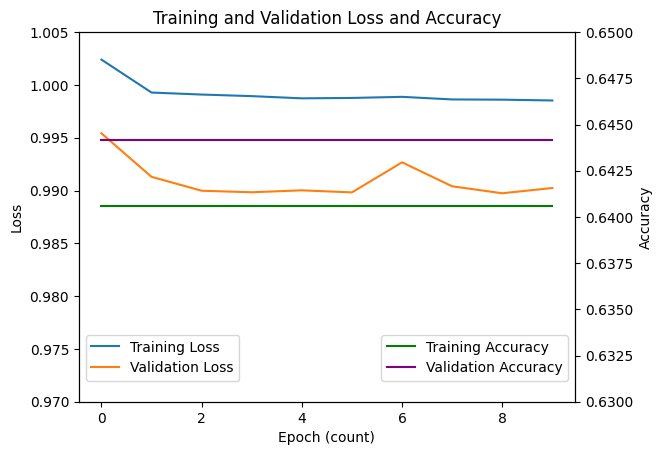

In [36]:
fig, ax1 = plt.subplots()

# Plotting the training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch (count)')
ax1.set_ylabel('Loss')
ax1.set_ylim([0.970,1.005])
ax1.legend(loc='upper left', bbox_to_anchor=(0., 0.2))

# Creating a twin y-axis for accuracy
ax2 = ax1.twinx()

# Plotting the training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='green')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='purple')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0.630,0.650])  # Set the range of the accuracy axis
ax2.legend(loc='upper right', bbox_to_anchor=(1., 0.2))

plt.title('Training and Validation Loss and Accuracy')
plt.show()

In [37]:
#Predicting with Test data
from sklearn.metrics import classification_report

y_pred_test = model.predict(test_word_vectors)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
target_names = ['Joe Biden', 'Narendra Modi', 'Trump', 'Obama'] 


552/552 [==============================] - 4s 6ms/step


In [38]:
y_pred_train = model.predict(train_word_vectors)
y_pred_train_classes = np.argmax( y_pred_train, axis=1)

2206/2206 [==============================] - 11s 5ms/step


In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [41]:
accuracy_score(y_train, y_pred_train_classes)

0.6406161432944111

In [42]:
precision_score(y_test, y_pred_test_classes, average = 'micro' )

0.644144654801043

In [43]:
recall_score(y_test, y_pred_test_classes, average = 'micro' )

0.644144654801043

In [44]:
accuracy_score(y_test, y_pred_test_classes)

0.644144654801043

In [45]:
y.value_counts()

3    56571
1    18724
2     6851
0     6064
Name: User, dtype: int64